In [ ]:
from pathlib import Path
import os
import re
import html
import string

import unicodedata


import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer

from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras import models
from keras import layers
from keras import losses
from keras import metrics
from keras import optimizers
from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from collections import Counter
from pathlib import Path
import os
import numpy as np
import re
import string
from nltk.stem.porter import PorterStemmer
from nltk.corpus import wordnet
import unicodedata
import html
stop_words = stopwords.words('english')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
DATA_PATH=Path('./dat/')
DATA_PATH.mkdir(exist_ok=True)
#if not os.path.exists('./dat/aclImdb_v1.tar.gz'):
if not os.path.exists('./dat/aclImdb'):
    !curl -O http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz 
    !tar -xf aclImdb_v1.tar.gz -C {DATA_PATH}

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  52.4M      0  0:00:01  0:00:01 --:--:-- 52.4M


In [ ]:
import numpy as np
CLASSES = ['neg', 'pos']#, 'unsup']
PATH=Path('./dat/aclImdb/')

def get_texts(path):
    texts,labels = [],[]
    for idx,label in enumerate(CLASSES):
        for fname in (path/label).glob('*.*'):
            #texts.append(fixup(fname.open('r', encoding='utf-8').read()))
            texts.append(fname.open('r', encoding='utf-8').read())
            labels.append(idx)
    #return np.array(texts),np.array(labels)
    return texts, labels

trn_texts,trn_labels = get_texts(PATH/'train')
tst_texts,tst_labels = get_texts(PATH/'test')

In [ ]:
def remove_special_chars(text):
    re1 = re.compile(r'  +')
    x1 = text.lower().replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>', 'u_n').replace(' @.@ ', '.').replace(
        ' @-@ ', '-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x1))


def remove_non_ascii(text):
    """Remove non-ASCII characters from list of tokenized words"""
    return unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')


def to_lowercase(text):
    return text.lower()



def remove_punctuation(text):
    """Remove punctuation from list of tokenized words"""
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)


def replace_numbers(text):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    return re.sub(r'\d+', '', text)


def remove_whitespaces(text):
    return text.strip()


def remove_stopwords(words, stop_words):
    """
    :param words:
    :type words:
    :param stop_words: from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
    or
    from spacy.lang.en.stop_words import STOP_WORDS
    :type stop_words:
    :return:
    :rtype:
    """
    return [word for word in words if word not in stop_words]


def stem_words(words):
    """Stem words in text"""
    stemmer = PorterStemmer()
    return [stemmer.stem(word) for word in words]

def lemmatize_words(words):
    """Lemmatize words in text"""

    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in words]

def lemmatize_verbs(words):
    """Lemmatize verbs in text"""

    lemmatizer = WordNetLemmatizer()
    return ' '.join([lemmatizer.lemmatize(word, pos='v') for word in words])

def text2words(text):
  return word_tokenize(text)

def normalize_text( text):
    text = remove_special_chars(text)
    text = remove_non_ascii(text)
    text = remove_punctuation(text)
    text = to_lowercase(text)
    text = replace_numbers(text)
    words = text2words(text)
    stop_words = stopwords.words('english')
    words = remove_stopwords(words, stop_words)
    #words = stem_words(words)# Either stem or lemmatize
    words = lemmatize_words(words)
    words = lemmatize_verbs(words)

    return ''.join(words)

In [ ]:
def normalize_corpus(corpus):
  return [normalize_text(t) for t in corpus]

In [ ]:
trn_texts = normalize_corpus(trn_texts)
tst_texts = normalize_corpus(tst_texts)

In [ ]:
vocab_sz = 10000
tok = Tokenizer(num_words=vocab_sz, oov_token='UNK')
texts = trn_texts + tst_texts
tok.fit_on_texts(texts)

In [ ]:
print(tok.word_index)

{'UNK': 1, 'movie': 2, 'film': 3, 'one': 4, 'make': 5, 'like': 6, 'see': 7, 'get': 8, 'time': 9, 'good': 10, 'character': 11, 'watch': 12, 'go': 13, 'even': 14, 'story': 15, 'think': 16, 'would': 17, 'really': 18, 'show': 19, 'scene': 20, 'well': 21, 'look': 22, 'say': 23, 'much': 24, 'know': 25, 'end': 26, 'people': 27, 'great': 28, 'bad': 29, 'also': 30, 'give': 31, 'first': 32, 'take': 33, 'act': 34, 'play': 35, 'love': 36, 'way': 37, 'dont': 38, 'come': 39, 'thing': 40, 'find': 41, 'could': 42, 'life': 43, 'seem': 44, 'work': 45, 'many': 46, 'plot': 47, 'actor': 48, 'want': 49, 'two': 50, 'never': 51, 'year': 52, 'try': 53, 'best': 54, 'little': 55, 'ever': 56, 'better': 57, 'man': 58, 'still': 59, 'feel': 60, 'part': 61, 'something': 62, 'lot': 63, 'back': 64, 'interest': 65, 'im': 66, 'director': 67, 'real': 68, 'guy': 69, 'performance': 70, 'doesnt': 71, 'use': 72, 'didnt': 73, 'woman': 74, 'though': 75, 'funny': 76, 'cast': 77, 'another': 78, 'actually': 79, 'nothing': 80, 'rol

In [ ]:
x_train = tok.texts_to_sequences(trn_texts)
x_test = tok.texts_to_sequences(tst_texts)
y_train = np.asarray(trn_labels).astype('float32')
y_test = np.asarray(tst_labels).astype('float32')

In [ ]:
def get_max_len(texts):
  return max([len(word_tokenize(text)) for text in texts])

def pad_seq(seq, maxlen):  
  return np.array(pad_sequences(seq, maxlen=maxlen, padding='post', truncating='post'))

In [ ]:
maxlen = get_max_len(texts)
print(maxlen)
#maxlen = 100
x_train = pad_seq(x_train, maxlen)
x_test = pad_seq(x_test, maxlen)

1428


In [ ]:
print(x_train.shape)
print(x_test.shape)

(25000, 1428)
(25000, 1428)


In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.4, random_state=42, shuffle=True)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Embedding
from keras.layers import LSTM


embedding_size = 100




# Model 1: Simple LSTM, with Embedding mask_zero
model = Sequential()
model.add(Embedding(vocab_sz+1, embedding_size, mask_zero=True, input_length=maxlen))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))



model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1428, 100)         1000100   
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 1,080,601
Trainable params: 1,080,601
Non-trainable params: 0
_________________________________________________________________


In [ ]:
'''
# Mount GDrive
from google.colab import drive
drive.mount('/content/gdrive')
gdrive_path = 'gdrive/My Drive/Colab Notebooks/DL NLP Course'

from keras.callbacks import ModelCheckpoint, Callback
model_name = 'basic'
filepath = os.path.join(gdrive_path, 'imdb_lstm_' + model_name + '.h5')
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
'''
checkpoint = EarlyStopping(monitor='val_accuracy', mode='max')
callbacks_lst = [checkpoint]

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

callbacks_lst = [checkpoint]
# Training
batch_size = 256
epochs = 20
print('Train...')
history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,          
          validation_data=(x_val, y_val),
          #validation_split=0.2,
          callbacks=callbacks_lst)

history_dict = history.history
history_dict.keys()

Train...
Epoch 1/20
59/59 [==============================] - 15s 89ms/step - loss: 0.5069 - accuracy: 0.7685 - val_loss: 0.3402 - val_accuracy: 0.8595
Epoch 2/20
59/59 [==============================] - 4s 65ms/step - loss: 0.2528 - accuracy: 0.9029 - val_loss: 0.3113 - val_accuracy: 0.8733


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

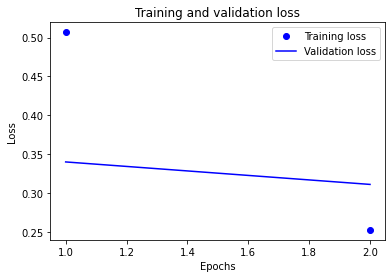

In [ ]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

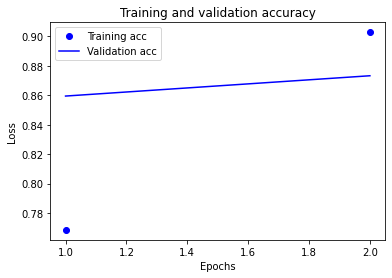

In [ ]:

plt.clf()   # clear figure
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Embedding
from keras.layers import LSTM


embedding_size = 100




# Model 1: Simple LSTM, with Embedding mask_zero
model = Sequential()
model.add(Embedding(vocab_sz+1, embedding_size, input_length=maxlen))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))



model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 1428, 100)         1000100   
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 1,080,601
Trainable params: 1,080,601
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

callbacks_lst = [checkpoint]
# Training
batch_size = 256
epochs = 20
print('Train...')
history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,          
          validation_data=(x_val, y_val),
          #validation_split=0.2,
          callbacks=callbacks_lst)

history_dict = history.history
history_dict.keys()

Train...
Epoch 1/20
59/59 [==============================] - 12s 161ms/step - loss: 0.6935 - accuracy: 0.4973 - val_loss: 0.6937 - val_accuracy: 0.4962
Epoch 2/20
59/59 [==============================] - 9s 153ms/step - loss: 0.6934 - accuracy: 0.4940 - val_loss: 0.6931 - val_accuracy: 0.5038


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Embedding
from keras.layers import LSTM


embedding_size = 100




# Model 1: Simple LSTM, with Embedding mask_zero
model = Sequential()
model.add(Embedding(vocab_sz+1, embedding_size, input_length=100))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))



model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 100)          1000100   
                                                                 
 lstm_2 (LSTM)               (None, 100)               80400     
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 1,080,601
Trainable params: 1,080,601
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# model.compile(loss='binary_crossentropy',
#               optimizer='adam',
#               metrics=['accuracy'])

# callbacks_lst = [checkpoint]
# # Training
# batch_size = 256
# epochs = 20
# print('Train...')
# history = model.fit(x_train, y_train,
#           batch_size=batch_size,
#           epochs=epochs,          
#           validation_data=(x_val, y_val),
#           #validation_split=0.2,
#           callbacks=callbacks_lst)

# history_dict = history.history
# history_dict.keys()

In [ ]:
model = Sequential()
model.add(Embedding(vocab_sz+1, embedding_size, mask_zero=True, input_length=maxlen))
model.add(layers.Bidirectional(LSTM(100)))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,          
          validation_data=(x_val, y_val),
          #validation_split=0.2,
          callbacks=callbacks_lst)

Epoch 1/20
59/59 [==============================] - 19s 178ms/step - loss: 0.5011 - accuracy: 0.7461 - val_loss: 0.3730 - val_accuracy: 0.8383
Epoch 2/20
59/59 [==============================] - 7s 123ms/step - loss: 0.2575 - accuracy: 0.9029 - val_loss: 0.3103 - val_accuracy: 0.8738


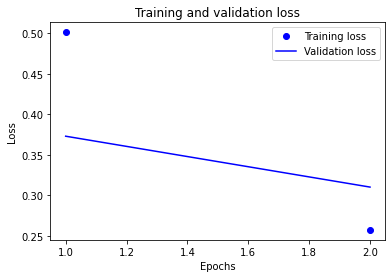

In [ ]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

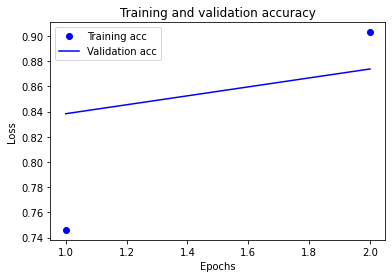

In [ ]:

plt.clf()   # clear figure
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
callbacks_lst

In [ ]:
model = Sequential()
model.add(Embedding(vocab_sz+1, embedding_size, mask_zero=True, input_length=maxlen))
model.add(layers.Bidirectional(layers.GRU(100)))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=20,          
          validation_data=(x_val, y_val),
          callbacks=callbacks_lst)

Epoch 1/20
59/59 [==============================] - 17s 171ms/step - loss: 0.5347 - accuracy: 0.7191 - val_loss: 0.3203 - val_accuracy: 0.8660
Epoch 2/20
59/59 [==============================] - 8s 136ms/step - loss: 0.2276 - accuracy: 0.9125 - val_loss: 0.3012 - val_accuracy: 0.8786
